In [1]:
!pip install umap-learn

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import scipy
import re
from matplotlib import pyplot as plt
from rouge import Rouge
import umap
import os

# Dataset

In [2]:
nltk.download('punkt')    

[nltk_data] Downloading package punkt to /home/nate/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/nate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", '3.0.0')

Reusing dataset cnn_dailymail (/home/nate/.cache/huggingface/datasets/ccdv___cnn_dailymail/3.0.0/3.0.0/0107f7388b5c6fae455a5661bcd134fc22da53ea75852027040d8d1e997f101f)


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [12]:
!wget http://mlg.ucd.ie/files/datasets/bbc.zip

--2022-04-22 12:17:10--  http://mlg.ucd.ie/files/datasets/bbc.zip
Resolving mlg.ucd.ie (mlg.ucd.ie)... 137.43.93.132
Connecting to mlg.ucd.ie (mlg.ucd.ie)|137.43.93.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 884338 (864K) [application/zip]
Saving to: ‘bbc.zip’

bbc.zip             100%[===================>] 863.61K  1.29MB/s    in 0.7s    

2022-04-22 12:17:12 (1.29 MB/s) - ‘bbc.zip’ saved [884338/884338]



# Pretrained word2vec

In [4]:
def load_embeddings(filename, skip_first_line=False, emb_dim=300):
    """ Returns an awesome dictionary that maps tokens to vectors
    NOTE: skip_first_line = False if glove else True

    Params:
        filename (str): name of vector file (likely with .vec suffix)
        skip_first_line (bool): is there a useless line at the top of the .vec file that we need to skip?
        emb_dim (int): embedding dimension of embeddings
    Returns:
        embeddings_dict (dict): dictionary mapping words to embeddings
            dict = { "word" (str) : vec (numpy.ndarray), ... }
    """
    with open(filename, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    embeddings_dict = {}
    if skip_first_line:
        # Skip the very first line because it's just info about the doc
        lines = lines[1:]
    for i, l in enumerate(lines):
        tokens = l.encode('utf-8').split()
        # embeddings_dict maps a string to a vector
        try:
            embeddings_dict[tokens[0]] = np.array([float(token) for token in tokens[-emb_dim:]])
        except:
            pdb.set_trace()
            while not tokens[1][3].isdigit():
                tokens = [tokens[0]+tokens[1]] + tokens[2:]
            # try again
            embeddings_dict[tokens[0]] = np.array([float(token) for token in tokens[1:]])
            assert len(embeddings_dict[tokens[0]]) == emb_dim
        
        try:
            float_tok = float(tokens[0])
            if '.' in tokens[0] and not (tokens[0].index('.') == len(tokens[0]) - 1):
                pdb.set_trace()
        except:
            pass

        if i%25000 ==0:
            print(i,flush=True)
            
    return embeddings_dict

In [5]:
target_embedding_path = "/home/nate/CODE/embeddings/all_embeds/word2vecC3.IN"
context_embedding_path = "/home/nate/CODE/embeddings/all_embeds/word2vecC3.OUT"

In [6]:
target_embeddings = load_embeddings(target_embedding_path)

0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000


In [7]:
context_embeddings = load_embeddings(context_embedding_path)

0
25000
50000
75000
100000
125000
150000
175000
200000
225000
250000
275000
300000
325000
350000
375000
400000
425000


# TextRank

In [8]:
def tokenize_sentences(document):
    sentences =[]        
    sentences = sent_tokenize(document)    
    for sentence in sentences:        
        sentence.replace("[^a-zA-Z0-9]"," ")     
    return sentences

In [9]:
def bow_cosine_similarity(sent1, sent2, stopwords=None, embedding_dict=None):    
    if stopwords is None:        
        stopwords = []        
    sent1 = [w.lower() for w in sent1]    
    sent2 = [w.lower() for w in sent2]

    all_words = list(set(sent1 + sent2))   

    vector1 = [0] * len(all_words)    
    vector2 = [0] * len(all_words)        
    #build the vector for the first sentence    
    for w in sent1:        
        if not w in stopwords:
            vector1[all_words.index(w)]+=1                                                             
    #build the vector for the second sentence    
    for w in sent2:        
        if not w in stopwords:            
            vector2[all_words.index(w)]+=1 

    return 1-cosine_distance(vector1,vector2)

In [10]:
def ngram_similarity(sent1, sent2, stopwords=None, embedding_dict=None):
    if stopwords is None:
        stopwords = []
    n1 = len(sent1)
    n2 = len(sent2)
    sent1 = [w.lower() for w in sent1.split()]
    sent2 = [w.lower() for w in sent2.split()]
    words = sent1 + sent2
    count = 0
    for word in words:
        if not word in stopwords:
            if word in sent1 and word in sent2:
                count += 1
    return count / (np.log(n1) + np.log(n2))

In [11]:
def w2v_similarity(sent1, sent2, stopwords, embedding_dict):
    sent1 = [w.lower() for w in sent1.split()]
    sent2 = [w.lower() for w in sent2.split()]
    
    # construct bag-of-words representation of sentences
    v1 = np.zeros(300)
    for i in range(len(sent1)):
        try:
            v1 += embedding_dict[sent1[i].encode()]
        except KeyError:
            pass
        
    v2 = np.zeros(300)
    for i in range(len(sent2)):
        try:
            v2 += embedding_dict[sent2[i].encode()]
        except KeyError:
            pass
    
    return 1 - scipy.spatial.distance.cosine(v1, v2)

In [12]:
def similarity_matrix(sentences, similarity_measure, stopwords=None, embedding_dict=None):
    n = len(sentences)
    sim_mat = np.zeros((n, n))
    # O(n^2)
    for i in range(n):
        for j in range(n):
            if embedding_dict is not None:
                sim_mat[i][j] = similarity_measure(sentences[i], sentences[j], stopwords, embedding_dict)
            else:
                sim_mat[i][j] = similarity_measure(sentences[i], sentences[j], stopwords)
    return sim_mat

In [30]:
def summarize(document, n, similarity_measure, stopwords=None, embedding_dict=None):
    # Tokenize sentences
    sentences = tokenize_sentences(document)
    
    # Build similarity matrix
    sim_mat = similarity_matrix(sentences, similarity_measure, stopwords, embedding_dict)
    
    # Rank sentences using page rank
    sim_graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(sim_graph, max_iter=10000)
    
    # Rank sentences
    ranked_sentences = sorted(((scores[i],s) for i,s in enumerate(sentences)),reverse=True)
    
    # Generate summary
    summary = []
    for i in range(n):
        summary.append(ranked_sentences[i][1])
        
    return " ".join(summary), len(sentences)

# BBC News

In [17]:
def get_articles(base_article_path, base_summary_path, files):
  articles = []
  summaries = []
  for file in files:
    with open(base_article_path+"/"+file, "r", encoding="unicode_escape") as f:
      articles.append(f.read())
    with open(base_summary_path+"/"+file, "r", encoding="unicode_escape") as f:
      summaries.append(f.read())
  
  return articles, summaries

In [18]:
business = os.listdir("BBC News Summary/News Articles/business")
entertainment = os.listdir("BBC News Summary/News Articles/entertainment")
politics = os.listdir("BBC News Summary/News Articles/politics")
sports = os.listdir("BBC News Summary/News Articles/sport")
tech = os.listdir("BBC News Summary/News Articles/tech")

In [19]:
business_articles, business_summaries = get_articles("BBC News Summary/News Articles/business", \
                                                     "BBC News Summary/Summaries/business", \
                                                     business)
entertainment_articles, entertainment_summaries = get_articles("BBC News Summary/News Articles/entertainment", \
                                                               "BBC News Summary/Summaries/entertainment", \
                                                               entertainment)
politics_articles, politics_summaries = get_articles("BBC News Summary/News Articles/politics", \
                                                     "BBC News Summary/Summaries/politics", \
                                                     politics)
sports_articles, sports_summaries = get_articles("BBC News Summary/News Articles/sport", \
                                                 "BBC News Summary/Summaries/sport", \
                                                 sports)
tech_articles, tech_summaries = get_articles("BBC News Summary/News Articles/tech", \
                                             "BBC News Summary/Summaries/tech", \
                                             tech)

# BBC News TextRank Experiments

In [24]:
stop_words = stopwords.words('english') 
rouge = Rouge()

In [43]:
target_business = {"1": [], "2": [], "L": []}
context_business = {"1": [], "2": [], "L": []}
i = 0
for article, highlight in zip(business_articles, business_summaries):
    # target summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=target_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    target_business["1"].append(scores["rouge-1"]["f"])
    target_business["2"].append(scores["rouge-2"]["f"])
    target_business["L"].append(scores["rouge-l"]["f"])
    
    # context summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=context_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    context_business["1"].append(scores["rouge-1"]["f"])
    context_business["2"].append(scores["rouge-2"]["f"])
    context_business["L"].append(scores["rouge-l"]["f"])
    
    if i % 50 == 0:
        print(i)
    
    i += 1
    
print("target rouge-1", np.mean(target_business["1"]))
print("target rouge-2", np.mean(target_business["2"]))
print("target rouge-L", np.mean(target_business["L"]))
print()
print("context rouge-1", np.mean(context_business["1"]))
print("context rouge-2", np.mean(context_business["2"]))
print("context rouge-L", np.mean(context_business["L"]))

0
50
100
150
200
250
300
350
400
450
500
target rouge-1 0.5425430148723613
target rouge-2 0.4287122137845125
target rouge-L 0.532401312954358

context rouge-1 0.5674636996688391
context rouge-2 0.45827095489469094
context rouge-L 0.5586380118116964


In [42]:
target_entertainment = {"1": [], "2": [], "L": []}
context_entertainment = {"1": [], "2": [], "L": []}
i = 0
for article, highlight in zip(entertainment_articles, entertainment_summaries):
    # target summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=target_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    target_entertainment["1"].append(scores["rouge-1"]["f"])
    target_entertainment["2"].append(scores["rouge-2"]["f"])
    target_entertainment["L"].append(scores["rouge-l"]["f"])
    
    # context summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=context_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    context_entertainment["1"].append(scores["rouge-1"]["f"])
    context_entertainment["2"].append(scores["rouge-2"]["f"])
    context_entertainment["L"].append(scores["rouge-l"]["f"])
    
    if i % 50 == 0:
        print(i)
    
    i += 1
    
print("target rouge-1", np.mean(target_entertainment["1"]))
print("target rouge-2", np.mean(target_entertainment["2"]))
print("target rouge-L", np.mean(target_entertainment["L"]))
print()
print("context rouge-1", np.mean(context_entertainment["1"]))
print("context rouge-2", np.mean(context_entertainment["2"]))
print("context rouge-L", np.mean(context_entertainment["L"]))

0
50
100
150
200
250
300
350
target rouge-1 0.5416826387142711
target rouge-2 0.43542617766859765
target rouge-L 0.5325591263247877

context rouge-1 0.5657993455510716
context rouge-2 0.45833600701959804
context rouge-L 0.5567330002328924


In [44]:
target_politics = {"1": [], "2": [], "L": []}
context_politics = {"1": [], "2": [], "L": []}
i = 0
for article, highlight in zip(politics_articles, politics_summaries):
    # target summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=target_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    target_politics["1"].append(scores["rouge-1"]["f"])
    target_politics["2"].append(scores["rouge-2"]["f"])
    target_politics["L"].append(scores["rouge-l"]["f"])
    
    # context summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=context_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    context_politics["1"].append(scores["rouge-1"]["f"])
    context_politics["2"].append(scores["rouge-2"]["f"])
    context_politics["L"].append(scores["rouge-l"]["f"])
    
    if i % 50 == 0:
        print(i)
    
    i += 1
    
print("target rouge-1", np.mean(target_politics["1"]))
print("target rouge-2", np.mean(target_politics["2"]))
print("target rouge-L", np.mean(target_politics["L"]))
print()
print("context rouge-1", np.mean(context_politics["1"]))
print("context rouge-2", np.mean(context_politics["2"]))
print("context rouge-L", np.mean(context_politics["L"]))

0
50
100
150
200
250
300
350
400
target rouge-1 0.5372009751430405
target rouge-2 0.4276518268172094
target rouge-L 0.5263915668989169

context rouge-1 0.5281752005732037
context rouge-2 0.41182480402834887
context rouge-L 0.5176754380614679


In [46]:
target_sports = {"1": [], "2": [], "L": []}
context_sports = {"1": [], "2": [], "L": []}
i = 0
for article, highlight in zip(sports_articles, sports_summaries):
    # target summary
    try:
        summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=target_embeddings)
    except:
        continue
    scores = rouge.get_scores(summary, highlight)[0]
    target_sports["1"].append(scores["rouge-1"]["f"])
    target_sports["2"].append(scores["rouge-2"]["f"])
    target_sports["L"].append(scores["rouge-l"]["f"])
    
    # context summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=context_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    context_sports["1"].append(scores["rouge-1"]["f"])
    context_sports["2"].append(scores["rouge-2"]["f"])
    context_sports["L"].append(scores["rouge-l"]["f"])
    
    if i % 50 == 0:
        print(i)
    
    i += 1
    
print("target rouge-1", np.mean(target_sports["1"]))
print("target rouge-2", np.mean(target_sports["2"]))
print("target rouge-L", np.mean(target_sports["L"]))
print()
print("context rouge-1", np.mean(context_sports["1"]))
print("context rouge-2", np.mean(context_sports["2"]))
print("context rouge-L", np.mean(context_sports["L"]))

0
50
100
150
200
250
300
350
400
450
500
target rouge-1 0.5204186873058985
target rouge-2 0.41204452910686484
target rouge-L 0.5104102826594811

context rouge-1 0.5294455351833616
context rouge-2 0.4177728102079702
context rouge-L 0.5192517238535593


In [47]:
target_tech = {"1": [], "2": [], "L": []}
context_tech = {"1": [], "2": [], "L": []}
i = 0
for article, highlight in zip(tech_articles, tech_summaries):
    # target summary
    try:
        summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=target_embeddings)
    except:
        continue
    try:
        scores = rouge.get_scores(summary, highlight)[0]
    except:
        continue
    target_tech["1"].append(scores["rouge-1"]["f"])
    target_tech["2"].append(scores["rouge-2"]["f"])
    target_tech["L"].append(scores["rouge-l"]["f"])
    
    # context summary
    summary, _ = summarize(article, 3, w2v_similarity, embedding_dict=context_embeddings)
    scores = rouge.get_scores(summary, highlight)[0]
    context_tech["1"].append(scores["rouge-1"]["f"])
    context_tech["2"].append(scores["rouge-2"]["f"])
    context_tech["L"].append(scores["rouge-l"]["f"])
    
    if i % 50 == 0:
        print(i)
    
    i += 1
    
print("target rouge-1", np.mean(target_tech["1"]))
print("target rouge-2", np.mean(target_tech["2"]))
print("target rouge-L", np.mean(target_tech["L"]))
print()
print("context rouge-1", np.mean(context_tech["1"]))
print("context rouge-2", np.mean(context_tech["2"]))
print("context rouge-L", np.mean(context_tech["L"]))

0
50
100
150
200
250
300
350
400
target rouge-1 0.49210714212948176
target rouge-2 0.3685661796295605
target rouge-L 0.4808436792128448

context rouge-1 0.49855760736933735
context rouge-2 0.37113195428931295
context rouge-L 0.4867380537888442


In [56]:
target_all_r1 = target_tech["L"] + target_entertainment["L"] + target_politics["L"] + \
                target_sports["L"] + target_tech["L"]
context_all_r1 = context_tech["L"] + context_entertainment["L"] + context_politics["L"] + \
                context_sports["L"] + context_tech["L"]
from scipy.stats import ttest_ind
ttest_ind(target_all_r1, context_all_r1)

Ttest_indResult(statistic=-1.4080205847264073, pvalue=0.15919849618893975)

# Experiments
### Base Methods

In [74]:
article = dataset["test"]["article"][25]
highlights = dataset["test"]["highlights"][25]

In [36]:
rouge = Rouge()

In [76]:
stop_words = stopwords.words('english')   

In [77]:
cos_similarity_summary = summarize(article, 3, bow_cosine_similarity, stop_words)
print("Cosine Similarity Summary:", cos_similarity_summary[0], sep="\n")
print()
ngram_similarity_summary = summarize(article, 3, ngram_similarity, stop_words)
print("N-Gram Similarity Summary:", ngram_similarity_summary[0], sep="\n")
print()
print("Target Summary:", highlights, sep="\n")

Cosine Similarity Summary:
Nairobi, Kenya (CNN)University of Nairobi students were terrified Sunday morning when they heard explosions -- caused by a faulty electrical cable -- and believed it was a terror attack, the school said. Kenya Power authorities and its CEO are at the school and looking into the electrical issue. The confusion and panic came less than two weeks after Al-Shabaab slaughtered 147 people at a college in Garissa, Kenya.

N-Gram Similarity Summary:
Nairobi, Kenya (CNN)University of Nairobi students were terrified Sunday morning when they heard explosions -- caused by a faulty electrical cable -- and believed it was a terror attack, the school said. Students on the Kikuyu campus stampeded down the halls of the Kimberly dormitory, and some jumped from its fifth floor, the university said. Almost all of the 54 students being treated at PCEA Kikuyu Hospital have been released, the university said.

Target Summary:
Students stampeded; some jumped from a fifth story at a 

In [78]:
cos_sim_scores = rouge.get_scores(cos_similarity_summary[0], highlights)[0]['rouge-1']
print("Cosine Similarity Rouge Scores: ", cos_sim_scores, sep="\n")
ngram_scores = rouge.get_scores(ngram_similarity_summary[0], highlights)[0]['rouge-1']
print("N-Gram Similarity Rouge Scores: ", ngram_scores, sep="\n")

Cosine Similarity Rouge Scores: 
{'r': 0.4878048780487805, 'p': 0.36363636363636365, 'f': 0.41666666177300354}
N-Gram Similarity Rouge Scores: 
{'r': 0.3902439024390244, 'p': 0.2807017543859649, 'f': 0.3265306073781758}


### Using Semantic Similarity

In [79]:
target_embedding_summary = summarize(article, 3, w2v_similarity, stopwords, target_embeddings)
print("Target Embedding Summary: ", target_embedding_summary[0], sep="\n")
print()
context_embedding_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
print("Context Embedding Summary: ", context_embedding_summary[0], sep="\n")
print()
print("Target Summary:", highlights, sep="\n")
print()
target_scores = rouge.get_scores(target_embedding_summary[0], highlights)[0]['rouge-1']
print("Target Rouge Scores: ", target_scores, sep="\n")
context_scores = rouge.get_scores(context_embedding_summary[0], highlights)[0]['rouge-1']
print("Context Rouge Scores: ", context_scores, sep="\n")

Target Embedding Summary: 
Almost all of the 54 students being treated at PCEA Kikuyu Hospital have been released, the university said. Among them, at least 63 students have been discharged, and at least four are slated for surgery, the school said. The confusion and panic came less than two weeks after Al-Shabaab slaughtered 147 people at a college in Garissa, Kenya.

Context Embedding Summary: 
Almost all of the 54 students being treated at PCEA Kikuyu Hospital have been released, the university said. Nairobi, Kenya (CNN)University of Nairobi students were terrified Sunday morning when they heard explosions -- caused by a faulty electrical cable -- and believed it was a terror attack, the school said. Students on the Kikuyu campus stampeded down the halls of the Kimberly dormitory, and some jumped from its fifth floor, the university said.

Target Summary:
Students stampeded; some jumped from a fifth story at a dorm; one student died, school officials say .
The blasts were caused by 

# Testing

In [ ]:
bow_scores = {"1": [], "2": [], "L": []}
n_gram_scores = {"1": [], "2": [], "L": []}
test = dataset["test"]
test_indices = np.arange(len(test))
np.random.shuffle(test_indices)
test_indices = test_indices[:500]
for i, idx in enumerate(test_indices):
    article = test["article"][idx]
    highlights = test["highlights"][idx]
    
    target_summary = summarize(article, 3, bow_cosine_similarity, stopwords=stop_words)
    scores = rouge.get_scores(target_summary[0], highlights)[0]
    bow_scores["1"].append(scores["rouge-1"]["f"])
    bow_scores["2"].append(scores["rouge-2"]["f"])
    bow_scores["L"].append(scores["rouge-l"]["f"])
    
    context_summary = summarize(article, 3, ngram_similarity, stopwords=stop_words)
    scores = rouge.get_scores(context_summary[0], highlights)[0]
    n_gram_scores["1"].append(scores["rouge-1"]["f"])
    n_gram_scores["2"].append(scores["rouge-2"]["f"])
    n_gram_scores["L"].append(scores["rouge-l"]["f"])
    
    if i % 10 == 0:
        print(i)

0
10
20


In [ ]:
print("bow mean rouge scores: ", np.mean(bow_scores["r"]))
print("n gram mean rouge scores: ", np.mean(n_gram_scores["r"]))

In [36]:
target_scores = {"1": [], "2": [], "L": []}
context_scores = {"1": [], "2": [], "L": []}
for i, idx in enumerate(test_indices):
    article = test["article"][idx]
    highlights = test["highlights"][idx]
    
    target_summary = summarize(article, 3, w2v_similarity, stopwords, target_embeddings)
    scores = rouge.get_scores(target_summary[0], highlights)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    
    context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    scores = rouge.get_scores(context_summary[0], highlights)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    
    if i % 10 == 0:
        print(i)
    

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


KeyError: 'r'

In [38]:
print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))

print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))

print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))

target embedding mean rouge-1 scores:  0.25334375015645244
context embedding mean rouge-1 scores:  0.2641069037352692
target embedding mean rouge-2 scores:  0.07373836767943234
context embedding mean rouge-2 scores:  0.081666750998527
target embedding mean rouge-L scores:  0.22810958723690078
context embedding mean rouge-L scores:  0.23807968970506777


In [33]:
from scipy.stats import ttest_ind
ttest_ind(target_scores["r"], context_scores["r"])

Ttest_indResult(statistic=-2.3439988122790347, pvalue=0.019273609593215092)

# K-Means

In [12]:
!pip install kaggle

     |████████████████████████████████| 58 kB 3.2 MB/s eta 0:00:011
     |████████████████████████████████| 78 kB 10.7 MB/s eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=5711b5305ee460b99f12bedffaccdd29662578d99849ce042d6cf407247d47a3
  Stored in directory: /home/nate/.cache/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle


In [23]:
import os

In [21]:
!kaggle datasets download -d pariza/bbc-news-summary

 56%|█████████████████████▎                | 5.00M/8.91M [00:00<00:00, 48.6MB/s]
100%|██████████████████████████████████████| 8.91M/8.91M [00:00<00:00, 64.1MB/s]


In [25]:
business = os.listdir("BBC News Summary/News Articles/business")
entertainment = os.listdir("BBC News Summary/News Articles/entertainment")
politices = os.listdir("BBC News Summary/News Articles/politics")
sports = os.listdir("BBC News Summary/News Articles/sport")
tech = os.listdir("BBC News Summary/News Articles/tech")

In [52]:
sports

['086.txt',
 '023.txt',
 '426.txt',
 '244.txt',
 '322.txt',
 '496.txt',
 '262.txt',
 '033.txt',
 '444.txt',
 '174.txt',
 '187.txt',
 '485.txt',
 '117.txt',
 '127.txt',
 '433.txt',
 '329.txt',
 '400.txt',
 '360.txt',
 '363.txt',
 '102.txt',
 '450.txt',
 '284.txt',
 '067.txt',
 '328.txt',
 '235.txt',
 '077.txt',
 '301.txt',
 '046.txt',
 '225.txt',
 '013.txt',
 '396.txt',
 '176.txt',
 '465.txt',
 '034.txt',
 '182.txt',
 '429.txt',
 '130.txt',
 '412.txt',
 '103.txt',
 '157.txt',
 '237.txt',
 '374.txt',
 '019.txt',
 '313.txt',
 '296.txt',
 '014.txt',
 '292.txt',
 '218.txt',
 '287.txt',
 '333.txt',
 '416.txt',
 '016.txt',
 '089.txt',
 '227.txt',
 '242.txt',
 '338.txt',
 '508.txt',
 '417.txt',
 '501.txt',
 '368.txt',
 '171.txt',
 '053.txt',
 '140.txt',
 '041.txt',
 '121.txt',
 '061.txt',
 '009.txt',
 '149.txt',
 '208.txt',
 '337.txt',
 '004.txt',
 '175.txt',
 '107.txt',
 '007.txt',
 '276.txt',
 '385.txt',
 '181.txt',
 '489.txt',
 '001.txt',
 '431.txt',
 '377.txt',
 '492.txt',
 '388.txt',
 '05

In [39]:
business_idx = np.arange(len(business))
np.random.shuffle(business_idx)
business_idx = business_idx[:200]

entertainment_idx = np.arange(len(entertainment))
np.random.shuffle(entertainment_idx)
entertainment_idx = entertainment_idx[:200]

politices_idx = np.arange(len(politices))
np.random.shuffle(politices_idx)
politices_idx = politices_idx[:200]

sports_idx = np.arange(len(sports))
np.random.shuffle(sports_idx)
sports_idx = sports_idx[:200]

tech_idx = np.arange(len(tech))
np.random.shuffle(tech_idx)
tech_idx = tech_idx[:200]

In [57]:
def get_articles(base_article_path, base_summary_path, files):
  articles = []
  summaries = []
  for file in files:
    with open(base_article_path+"/"+file, "r", encoding="unicode_escape") as f:
      articles.append(f.read())
    with open(base_summary_path+"/"+file, "r", encoding="unicode_escape") as f:
      summaries.append(f.read())
  
  return articles, summaries

In [41]:
from sklearn.cluster import KMeans
import torch
# from sentence_transformers import SentenceTransformer

In [42]:
class kmeans_summary:
    def __init__(self, k, embeddings, w2v=True):
        self.k = k
        self.embeddings = embeddings
        self.w2v = w2v
        
    def summarize(self, doc):
        sentences = self.tokenize_sentences(doc)
        self.sentence_embeddings = self.embed_sentences(sentences)
        kmeans = KMeans(n_clusters=self.k, random_state=42).fit(self.sentence_embeddings)
        self.centroids = kmeans.cluster_centers_
        summary = []
        already_used = set()
        for centroid in self.centroids:
            closest_sent_indices = np.argsort(np.linalg.norm(centroid - self.sentence_embeddings, axis=1))
            for idx in closest_sent_indices:
                if idx not in already_used:
                    already_used.add(idx)
                    summary.append(sentences[idx])
                    break
                    
        return " ".join(summary), kmeans.inertia_
        
    def tokenize_sentences(self, document):
        sentences =[]        
        sentences = sent_tokenize(document)    
        for sentence in sentences:        
            sentence.replace("[^a-zA-Z0-9]"," ")     
        return sentences

    def embed_sentences(self, sentences):
        sentence_embeddings = []
        if self.w2v:
            # w2v
            for sent in sentences:
                sent = [w.lower() for w in sent.split()]
                # construct bag-of-words representation of sentences
                s_emb = np.zeros(300)
                for i in range(len(sent)):
                    try:
                        s_emb += self.embeddings[sent[i].encode()]
                    except KeyError:
                        pass
                sentence_embeddings.append(s_emb)
        else:
            # BERt
            sentence_embeddings = self.embeddings.encode(sentences)
        return np.array(sentence_embeddings)

In [44]:
# business_files = [business[idx] for idx in business_idx]
business_articles, business_summaries = get_articles("BBC News Summary/News Articles/business", "BBC News Summary/Summaries/business", business)

target_scores = {"1": [], "2": [], "L": [], "inertia": []}
context_scores = {"1": [], "2": [], "L": [], "inertia": []}
for article, highlight in zip(business_articles, business_summaries):
    # target_summary = summarize(article, 5, w2v_similarity, stopwords, target_embeddings)
    summarizer = kmeans_summary(3, target_embeddings, True)
    target_summary, target_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(target_summary, highlight)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    target_scores["inertia"].append(target_inertia)
    
    # context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    summarizer = kmeans_summary(3, context_embeddings, True)
    context_summary, context_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(context_summary, highlight)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    context_scores["inertia"].append(context_inertia)

print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))
print()
print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))
print()
print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))
print()
print("target embedding mean inertia: ", np.mean(target_scores["inertia"]))
print("context embeddings mean inertia: ", np.mean(context_scores["inertia"]))

target embedding mean rouge-1 scores:  0.48446779433505155
context embedding mean rouge-1 scores:  0.48507599694020426

target embedding mean rouge-2 scores:  0.3623159665490476
context embedding mean rouge-2 scores:  0.3626167926212006

target embedding mean rouge-L scores:  0.4744745503125241
context embedding mean rouge-L scores:  0.47567039079697754

target embedding mean inertia:  1831.590204272774
context embeddings mean inertia:  6635.402678283306


In [47]:
entertainment_articles, entertainment_summaries = get_articles("BBC News Summary/News Articles/entertainment", "BBC News Summary/Summaries/entertainment", entertainment)

target_scores = {"1": [], "2": [], "L": [], "inertia": []}
context_scores = {"1": [], "2": [], "L": [], "inertia": []}
for article, highlight in zip(entertainment_articles, entertainment_articles):
    # target_summary = summarize(article, 5, w2v_similarity, stopwords, target_embeddings)
    summarizer = kmeans_summary(3, target_embeddings, True)
    target_summary, target_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(target_summary, highlight)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    target_scores["inertia"].append(target_inertia)
    
    # context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    summarizer = kmeans_summary(3, context_embeddings, True)
    context_summary, context_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(context_summary, highlight)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    context_scores["inertia"].append(context_inertia)

print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))
print()
print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))
print()
print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))
print()
print("target embedding mean inertia: ", np.mean(target_scores["inertia"]))
print("context embeddings mean inertia: ", np.mean(context_scores["inertia"]))

target embedding mean rouge-1 scores:  0.4649592838917797
context embedding mean rouge-1 scores:  0.4600814217452546

target embedding mean rouge-2 scores:  0.3836113515824953
context embedding mean rouge-2 scores:  0.3755093359485161

target embedding mean rouge-L scores:  0.4649592838917797
context embedding mean rouge-L scores:  0.4600814217452546

target embedding mean inertia:  1972.1541542179739
context embeddings mean inertia:  7539.831847117401


In [49]:
politics_articles, politics_summaries = get_articles("BBC News Summary/News Articles/politics", "BBC News Summary/Summaries/politics", politices)

target_scores = {"1": [], "2": [], "L": [], "inertia": []}
context_scores = {"1": [], "2": [], "L": [], "inertia": []}
for article, highlight in zip(politics_articles, politics_summaries):
    # target_summary = summarize(article, 5, w2v_similarity, stopwords, target_embeddings)
    summarizer = kmeans_summary(3, target_embeddings, True)
    target_summary, target_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(target_summary, highlight)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    target_scores["inertia"].append(target_inertia)
    
    # context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    summarizer = kmeans_summary(3, context_embeddings, True)
    context_summary, context_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(context_summary, highlight)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    context_scores["inertia"].append(context_inertia)

print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))
print()
print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))
print()
print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))
print()
print("target embedding mean inertia: ", np.mean(target_scores["inertia"]))
print("context embeddings mean inertia: ", np.mean(context_scores["inertia"]))

target embedding mean rouge-1 scores:  0.43845072520420403
context embedding mean rouge-1 scores:  0.43987424727665364

target embedding mean rouge-2 scores:  0.31221194124999674
context embedding mean rouge-2 scores:  0.31332468549459197

target embedding mean rouge-L scores:  0.4259304006729022
context embedding mean rouge-L scores:  0.42856199010863577

target embedding mean inertia:  2949.7810391929734
context embeddings mean inertia:  10967.350713339454


In [58]:
sport_articles, sport_summaries = get_articles("BBC News Summary/News Articles/sport", "BBC News Summary/Summaries/sport", sports)

target_scores = {"1": [], "2": [], "L": [], "inertia": []}
context_scores = {"1": [], "2": [], "L": [], "inertia": []}
for article, highlight in zip(sport_articles, sport_articles):
    # target_summary = summarize(article, 5, w2v_similarity, stopwords, target_embeddings)
    summarizer = kmeans_summary(3, target_embeddings, True)
    target_summary, target_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(target_summary, highlight)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    target_scores["inertia"].append(target_inertia)
    
    # context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    summarizer = kmeans_summary(3, context_embeddings, True)
    context_summary, context_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(context_summary, highlight)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    context_scores["inertia"].append(context_inertia)

print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))
print()
print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))
print()
print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))
print()
print("target embedding mean inertia: ", np.mean(target_scores["inertia"]))
print("context embeddings mean inertia: ", np.mean(context_scores["inertia"]))

target embedding mean rouge-1 scores:  0.45478531306667214
context embedding mean rouge-1 scores:  0.454773778864706

target embedding mean rouge-2 scores:  0.3696538696931351
context embedding mean rouge-2 scores:  0.3670951366986988

target embedding mean rouge-L scores:  0.45478531306667214
context embedding mean rouge-L scores:  0.454773778864706

target embedding mean inertia:  1928.953702188919
context embeddings mean inertia:  7698.8427032012505


In [59]:
tech_articles, tech_summaries = get_articles("BBC News Summary/News Articles/tech", "BBC News Summary/Summaries/tech", tech)

target_scores = {"1": [], "2": [], "L": [], "inertia": []}
context_scores = {"1": [], "2": [], "L": [], "inertia": []}
for article, highlight in zip(tech_articles, tech_summaries):
    # target_summary = summarize(article, 5, w2v_similarity, stopwords, target_embeddings)
    summarizer = kmeans_summary(3, target_embeddings, True)
    target_summary, target_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(target_summary, highlight)[0]
    target_scores["1"].append(scores["rouge-1"]["f"])
    target_scores["2"].append(scores["rouge-2"]["f"])
    target_scores["L"].append(scores["rouge-l"]["f"])
    target_scores["inertia"].append(target_inertia)
    
    # context_summary = summarize(article, 3, w2v_similarity, stopwords, context_embeddings)
    summarizer = kmeans_summary(3, context_embeddings, True)
    context_summary, context_inertia = summarizer.summarize(article)
    scores = rouge.get_scores(context_summary, highlight)[0]
    context_scores["1"].append(scores["rouge-1"]["f"])
    context_scores["2"].append(scores["rouge-2"]["f"])
    context_scores["L"].append(scores["rouge-l"]["f"])
    context_scores["inertia"].append(context_inertia)

print("target embedding mean rouge-1 scores: ", np.mean(target_scores["1"]))
print("context embedding mean rouge-1 scores: ", np.mean(context_scores["1"]))
print()
print("target embedding mean rouge-2 scores: ", np.mean(target_scores["2"]))
print("context embedding mean rouge-2 scores: ", np.mean(context_scores["2"]))
print()
print("target embedding mean rouge-L scores: ", np.mean(target_scores["L"]))
print("context embedding mean rouge-L scores: ", np.mean(context_scores["L"]))
print()
print("target embedding mean inertia: ", np.mean(target_scores["inertia"]))
print("context embeddings mean inertia: ", np.mean(context_scores["inertia"]))

target embedding mean rouge-1 scores:  0.40735642936401506
context embedding mean rouge-1 scores:  0.3965494286804119

target embedding mean rouge-2 scores:  0.2708035441151582
context embedding mean rouge-2 scores:  0.25992063789610753

target embedding mean rouge-L scores:  0.39508979569909175
context embedding mean rouge-L scores:  0.384862509307733

target embedding mean inertia:  3133.4573033567003
context embeddings mean inertia:  11204.29195798604


In [61]:
from scipy.stats import ttest_ind
ttest_ind(target_scores["1"], context_scores["1"])

Ttest_indResult(statistic=1.1155955279127903, pvalue=0.26493029697549714)

# Visualizations

In [133]:
from matplotlib import pyplot as plt

In [7]:
target_norms = []
context_norms = []
for word in target_embeddings.keys():
    target_norms.append(np.linalg.norm(target_embeddings[word], ord=2))
    context_norms.append(np.linalg.norm(context_embeddings[word], ord=2))

In [8]:
target_norms.sort()
context_norms.sort()

In [9]:
target_norms = target_norms[:-1]
context_norms = context_norms[:-1]
target_norms[-1]

8.655810223338891

In [10]:
bins = np.linspace(0, 50, 100)

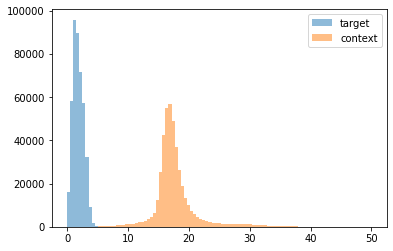

In [13]:
plt.hist(target_norms, bins, alpha=0.5, label="target")
plt.hist(context_norms, bins, alpha=0.5, label="context")
plt.legend(loc='upper right')
plt.savefig("norms_dist.png",  dpi=300)

In [30]:
target_stopword_norms = []
context_stop_word_norms = []
for word in stop_words:
    try:
        target_stopword_norms.append(np.linalg.norm(target_embeddings[word.encode()], ord=2))
    except KeyError:
        pass
    try:
        context_stop_word_norms.append(np.linalg.norm(context_embeddings[word.encode()], ord=2))
    except KeyError:
        pass

In [34]:
print("Target stopword norms: ", np.mean(target_stopword_norms))
print("Target average word norms: ", np.mean(target_norms))
print("Context stopword norms: ", np.mean(context_stop_word_norms))
print("Context average word norms: ", np.mean(context_norms))

Target stopword norms:  2.868715510650181
Target average word norms:  1.8506821390406325
Context stopword norms:  6.227275594849735
Context average word norms:  17.743070366603913


### U-MAP

In [168]:
article = test["article"][test_indices[326]]
highlights = test["highlights"][test_indices[326]]
summarizer = kmeans_summary(3, target_embeddings, True)
print(summarizer.summarize(article))
# print(highlights)

('The Jascon 4 had been 30m under water for three days and all 12 members of the crew were believed to have perished. Scroll down for videos . The two aircrafts were flying in formation and the skydivers had planned to jump in tandem.', 7706.523965428814)


In [172]:
target_scores["1"][326]

0.025974021015349236

In [170]:
X = np.concatenate([summarizer.sentence_embeddings, summarizer.centroids], axis=0)
X.shape

(50, 300)

In [174]:
# UMAP dimension reduction
reducer = umap.UMAP(metric="euclidean")
embedding = reducer.fit_transform(X)
embedding.shape

(50, 2)

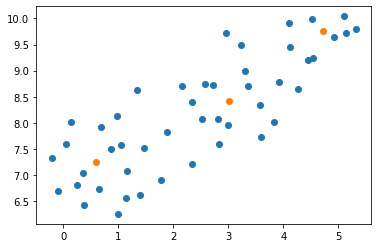

In [177]:
plt.scatter(embedding[:47,0], embedding[:47,1])
plt.scatter(embedding[47:,0], embedding[47:,1])

In [103]:
X_context = np.zeros((100, 300))
for i, key in enumerate(context_embeddings.keys()):
    if len(context_embeddings[key]) == 2:
        continue
    X_context[i,:] = context_embeddings[key]
    if i >= X_context.shape[0]-1:
        break
X_context.shape

(100, 300)

In [104]:
X_target = np.zeros((100, 300))
for i, key in enumerate(target_embeddings.keys()):
    if len(target_embeddings[key]) < 300:
        continue
    X_target[i,:] = target_embeddings[key]
    if i >= X_target.shape[0]-1:
        break
X_target.shape

(100, 300)

In [105]:
X = np.concatenate([X_context, X_target], axis=0)
X.shape

(200, 300)

In [106]:
# UMAP dimension reduction
reducer = umap.UMAP(metric="euclidean")
embedding = reducer.fit_transform(X)
embedding.shape

(200, 2)

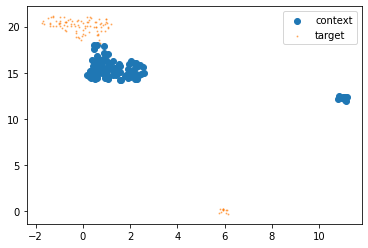

In [107]:
plt.scatter(embedding[:100, 0], embedding[:100, 1], label="context")
plt.scatter(embedding[100:, 0], embedding[100:, 1], label="target", alpha=0.5, s=1)
plt.legend()
plt.show()